In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils as pic

%load_ext autoreload
%autoreload 2

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.05    # Minimum time cutoff
tmax        = 0.05     # Maximum time cutoff
tstep       = 0.0049   # Time steps

In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [4]:
X_e_train, X_t_train, maxframes, time_bins = pic.timeordered_BC(X_train, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )

[-0.05   -0.0451 -0.0402 -0.0353 -0.0304 -0.0255 -0.0206 -0.0157 -0.0108
 -0.0059 -0.001   0.0039  0.0088  0.0137  0.0186  0.0235  0.0284  0.0333
  0.0382  0.0431  0.048 ]


In [5]:
%matplotlib qt
ani = pic.inline_animation(X_e_train,y_train,time_bins,event=0)
plt.show()

In [9]:
X_e_valid, X_t_valid, maxframes, time_bins = pic.timeordered_BC(X_valid, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )

[-0.05   -0.0451 -0.0402 -0.0353 -0.0304 -0.0255 -0.0206 -0.0157 -0.0108
 -0.0059 -0.001   0.0039  0.0088  0.0137  0.0186  0.0235  0.0284  0.0333
  0.0382  0.0431  0.048 ]


In [10]:
X_e_test, X_t_test, _, _ = pic.timeordered_BC(X_test, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep)

[-0.05   -0.0451 -0.0402 -0.0353 -0.0304 -0.0255 -0.0206 -0.0157 -0.0108
 -0.0059 -0.001   0.0039  0.0088  0.0137  0.0186  0.0235  0.0284  0.0333
  0.0382  0.0431  0.048 ]


In [6]:
model = keras.Sequential()

model.add(layers.Reshape((maxframes, 32, 32, 1),input_shape=(maxframes, 32, 32)))
model.add(layers.ConvLSTM2D(32, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(16,3,activation='relu',padding='same'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(25,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 21, 32, 32, 1)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 32, 32, 32)        38144     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [11]:
history = model.fit(
    X_e_train, y_train,
    validation_data=(X_e_valid,y_valid),
    epochs=5,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/5
32/32 [==============================] - 173s 5s/step - loss: 0.6829 - accuracy: 0.5547 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/5
32/32 [==============================] - 162s 5s/step - loss: 0.6696 - accuracy: 0.5850 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/5
32/32 [==============================] - 162s 5s/step - loss: 0.6624 - accuracy: 0.5962 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 4/5
32/32 [==============================] - 167s 5s/step - loss: 0.6676 - accuracy: 0.5962 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 5/5
32/32 [==============================] - 169s 5s/step - loss: 0.6524 - accuracy: 0.6138 - val_loss: 0.6894 - val_accuracy: 0.5166


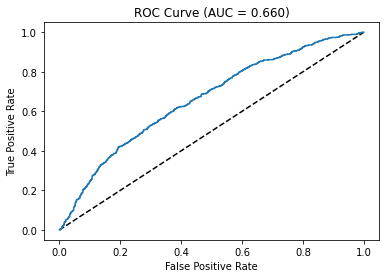

In [12]:
%matplotlib inline
pic.plot_roc(y_test, model.predict(X_e_test))

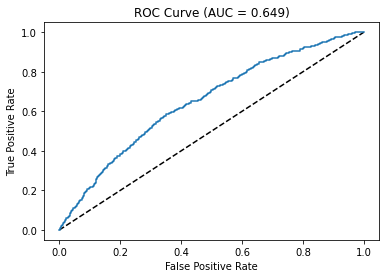

In [15]:
%matplotlib inline
pic.plot_roc(y_valid, model.predict(X_e_valid))

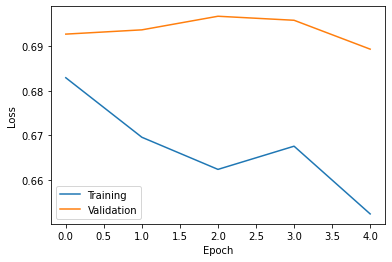

In [14]:
metric = 'loss'
loss = history.history[metric]
val_loss = history.history[f'val_{metric}']

plt.plot(loss,label='Training')
plt.plot(val_loss,label='Validation')
plt.xlabel('Epoch')
plt.ylabel(metric.capitalize())
plt.legend()
plt.show()